In [1]:
import torch
from transformers import MarianMTModel, MarianTokenizer

from test_utils import *

import json

/Users/justin/anaconda3/envs/py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the tokenizer and model
model_name = "Helsinki-NLP/opus-mt-en-de"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)
model.eval()


/Users/justin/anaconda3/envs/py3.11/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(58101, 512, padding_idx=58100)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(58101, 512, padding_idx=58100)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [51]:
from datasets import load_dataset

# Load the WMT14 English-German dataset
dataset = load_dataset('wmt19', 'de-en', split='validation')


In [52]:
import random

# Sample a subset of the dataset for quicker evaluation
sample_size = 100  # Adjust as needed
sampled_dataset = dataset.shuffle(seed=42).select(range(sample_size))

# Prepare the references and generate translations
references = sampled_dataset['translation']
source_texts = [item['en'] for item in references]
target_texts = [item['de'] for item in references]


In [53]:
# Create a dictionary to store the texts
data = {
    'source_texts': source_texts,
    'target_texts': target_texts
}

# Save the dictionary to a JSON file
with open('translations.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

In [3]:
# Load the JSON file
with open('translations.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract the source and target texts
source_texts = data['source_texts']
target_texts = data['target_texts']

In [4]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Ensure nltk is installed
nltk.download('punkt')

def compute_bleu_score(model,source_texts,target_texts):
    # Tokenize and generate translations
    generated_texts = []
    for source in source_texts:
        inputs = tokenizer.encode(source, return_tensors='pt', max_length=512, truncation=True)
        with torch.no_grad():
            translated_tokens = model.generate(inputs, max_length=512, num_beams=5, early_stopping=True)
        generated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
        generated_texts.append(generated_text)

    # Tokenize the reference and generated texts
    tokenized_references = [[nltk.word_tokenize(text)] for text in target_texts]
    tokenized_generated_texts = [nltk.word_tokenize(text) for text in generated_texts]

    # Calculate BLEU score
    smoothie = SmoothingFunction().method4
    bleu_score = corpus_bleu(tokenized_references, tokenized_generated_texts, smoothing_function=smoothie)

    return bleu_score*100


[nltk_data] Downloading package punkt to /Users/justin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
baseline_bleu = compute_bleu_score(model,source_texts,target_texts)

In [6]:
baseline_bleu

46.82103167541074

In [7]:
model.model.encoder

MarianEncoder(
  (embed_tokens): Embedding(58101, 512, padding_idx=58100)
  (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
  (layers): ModuleList(
    (0-5): 6 x MarianEncoderLayer(
      (self_attn): MarianAttention(
        (k_proj): Linear(in_features=512, out_features=512, bias=True)
        (v_proj): Linear(in_features=512, out_features=512, bias=True)
        (q_proj): Linear(in_features=512, out_features=512, bias=True)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (activation_fn): SiLU()
      (fc1): Linear(in_features=512, out_features=2048, bias=True)
      (fc2): Linear(in_features=2048, out_features=512, bias=True)
      (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
)

In [8]:
atten_block = model.model.encoder.layers[0].self_attn

In [9]:
k_weight = atten_block.k_proj.weight.detach().clone().numpy()

In [10]:
k_weight

array([[-0.0431658 ,  0.05314786,  0.01992885, ...,  0.05150389,
        -0.05855705, -0.06797506],
       [ 0.03430727, -0.03185176, -0.02637685, ..., -0.00773765,
         0.03985396,  0.02887879],
       [ 0.00455057, -0.00745978,  0.09381308, ..., -0.0922135 ,
        -0.13821538, -0.01102295],
       ...,
       [-0.03620727,  0.01365876,  0.05509148, ..., -0.01048039,
         0.00950968, -0.06236786],
       [-0.02010291,  0.08748431,  0.06102307, ...,  0.04928866,
        -0.11875598,  0.09157822],
       [-0.00318049,  0.05060565, -0.01177562, ...,  0.07342083,
        -0.03669421,  0.01891214]], dtype=float32)

In [8]:
def extract_weight_array(layer):
    atten_block = layer.self_attn
    
    k_weight = atten_block.k_proj.weight.detach().clone().numpy()
    v_weight = atten_block.v_proj.weight.detach().clone().numpy()
    q_weight = atten_block.q_proj.weight.detach().clone().numpy()

    return [k_weight,v_weight,q_weight]

In [9]:
original_atten_block_weight_array_0 = extract_weight_array(model.model.encoder.layers[0])
original_atten_block_weight_array_1 = extract_weight_array(model.model.encoder.layers[1])
original_atten_block_weight_array_2 = extract_weight_array(model.model.encoder.layers[2])
original_atten_block_weight_array_3 = extract_weight_array(model.model.encoder.layers[3])
original_atten_block_weight_array_4 = extract_weight_array(model.model.encoder.layers[4])
original_atten_block_weight_array_5 = extract_weight_array(model.model.encoder.layers[5])

In [10]:
def set_layer_weight(layer,atten_block_weight_array):
    layer.self_attn.k_proj.weight.data = torch.tensor(atten_block_weight_array[0],dtype=torch.float32)
    layer.self_attn.v_proj.weight.data = torch.tensor(atten_block_weight_array[1],dtype=torch.float32)
    layer.self_attn.q_proj.weight.data = torch.tensor(atten_block_weight_array[2],dtype=torch.float32)
    # layer.self_attn.q_proj.weight.data = torch.randn_like(layer.self_attn.q_proj.weight.data)

In [37]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)

In [11]:
baseline_bleu

46.82103167541074

In [55]:
bleu = compute_bleu_score(model,source_texts,target_texts)

In [56]:
bleu

46.82103167541074

In [102]:
import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/Code/main')
from iterative_approximation.Algorithm1 import *

import statistics

import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/Code')
from iterative_approximation.Algorithm2 import *
from iterative_approximation.Algorithm2Step import *
from iterative_approximation.Algorithm2StepPruning import *
from iterative_approximation.Algorithm1 import *
import itertools
from utils.generate_groupings import *
import matplotlib.cm as cm

from utils.load_layer_weights_from_txt import *
from utils.save_layer_weight_to_txt import *

In [14]:
W0 = WeightArrayStepPruning(original_atten_block_weight_array_0,'array',0.001,512,512,1,1)
W1 = WeightArrayStepPruning(original_atten_block_weight_array_1,'array',0.001,512,512,1,1)
W2 = WeightArrayStepPruning(original_atten_block_weight_array_2,'array',0.001,512,512,1,1)
W3 = WeightArrayStepPruning(original_atten_block_weight_array_3,'array',0.001,512,512,1,1)
W4 = WeightArrayStepPruning(original_atten_block_weight_array_4,'array',0.001,512,512,1,1)
W5 = WeightArrayStepPruning(original_atten_block_weight_array_5,'array',0.001,512,512,1,1)

In [93]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5)

mse = []
bleu_scores = []

for i in range(50):
    atten_block_weight_array_0 = W0.iterative_approximation_step1()
    atten_block_weight_array_1 = W1.iterative_approximation_step1()
    atten_block_weight_array_2 = W2.iterative_approximation_step1()
    atten_block_weight_array_3 = W3.iterative_approximation_step1()
    atten_block_weight_array_4 = W4.iterative_approximation_step1()
    atten_block_weight_array_5 = W5.iterative_approximation_step1()
    W0_MSE = (W0.average_mse_array()+W1.average_mse_array()+W2.average_mse_array()+W3.average_mse_array()+W4.average_mse_array()+W5.average_mse_array())/6
    mse.append(W0_MSE)

    set_layer_weight(model.model.encoder.layers[0],atten_block_weight_array_0)
    set_layer_weight(model.model.encoder.layers[1],atten_block_weight_array_1)
    set_layer_weight(model.model.encoder.layers[2],atten_block_weight_array_2)
    set_layer_weight(model.model.encoder.layers[3],atten_block_weight_array_3)
    set_layer_weight(model.model.encoder.layers[4],atten_block_weight_array_4)
    set_layer_weight(model.model.encoder.layers[5],atten_block_weight_array_5)
    bleu = compute_bleu_score(model,source_texts,target_texts)
    bleu_scores.append(bleu)


In [92]:
mse

[0.018023651637322276, 0.017569384538518976, 0.017126227841415445]

In [91]:
bleu_scores

[3.5172708438923466, 4.066229357478371, 4.279874737677521]

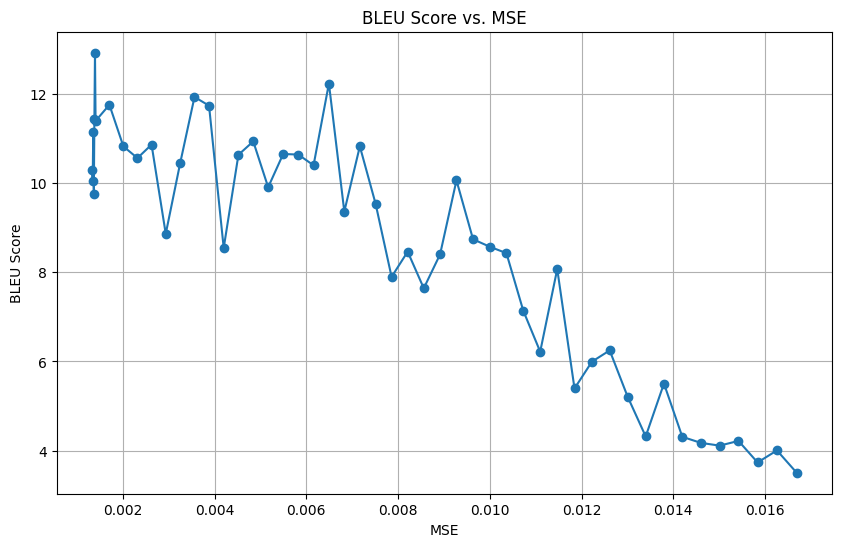

In [94]:
# Plotting BLEU against MSE
plt.figure(figsize=(10, 6))
plt.plot(mse, bleu_scores, marker='o')
plt.xlabel('MSE')
plt.ylabel('BLEU Score')
plt.title('BLEU Score vs. MSE')
plt.grid(True)
plt.show()

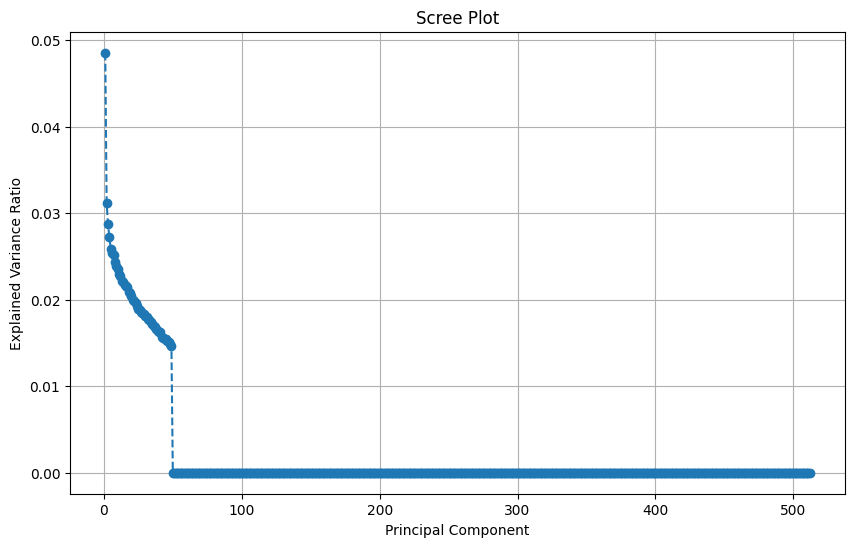

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Example matrix (replace this with your actual matrix)
matrix =  model.model.encoder.layers[0].self_attn.k_proj.weight.detach().clone().numpy() # 100 samples, 10 features

# Perform PCA
pca = PCA()
pca.fit(matrix)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Create the scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

In [18]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5)

W0 = WeightArrayStepPruning(original_atten_block_weight_array_0,'array',0.001,1,1,512,512)
W1 = WeightArrayStepPruning(original_atten_block_weight_array_1,'array',0.001,1,1,512,512)
W2 = WeightArrayStepPruning(original_atten_block_weight_array_2,'array',0.001,1,1,512,512)
W3 = WeightArrayStepPruning(original_atten_block_weight_array_3,'array',0.001,1,1,512,512)
W4 = WeightArrayStepPruning(original_atten_block_weight_array_4,'array',0.001,1,1,512,512)
W5 = WeightArrayStepPruning(original_atten_block_weight_array_5,'array',0.001,1,1,512,512)

mse = []
bleu_scores = []
compression_ratio = []

for i in range(150):
        atten_block_weight_array_0 = W0.iterative_approximation_step1()
        atten_block_weight_array_1 = W1.iterative_approximation_step1()
        atten_block_weight_array_2 = W2.iterative_approximation_step1()
        atten_block_weight_array_3 = W3.iterative_approximation_step1()
        atten_block_weight_array_4 = W4.iterative_approximation_step1()
        atten_block_weight_array_5 = W5.iterative_approximation_step1()

for i in range(18):
    for i in range(5):
        atten_block_weight_array_0 = W0.iterative_approximation_step1()
        atten_block_weight_array_1 = W1.iterative_approximation_step1()
        atten_block_weight_array_2 = W2.iterative_approximation_step1()
        atten_block_weight_array_3 = W3.iterative_approximation_step1()
        atten_block_weight_array_4 = W4.iterative_approximation_step1()
        atten_block_weight_array_5 = W5.iterative_approximation_step1()

    W0_MSE = (W0.average_mse_array()+W1.average_mse_array()+W2.average_mse_array()+W3.average_mse_array()+W4.average_mse_array()+W5.average_mse_array())/6
    mse.append(W0_MSE)
    compression_ratio.append(W0.compression_ratio())

    set_layer_weight(model.model.encoder.layers[0],atten_block_weight_array_0)
    set_layer_weight(model.model.encoder.layers[1],atten_block_weight_array_1)
    set_layer_weight(model.model.encoder.layers[2],atten_block_weight_array_2)
    set_layer_weight(model.model.encoder.layers[3],atten_block_weight_array_3)
    set_layer_weight(model.model.encoder.layers[4],atten_block_weight_array_4)
    set_layer_weight(model.model.encoder.layers[5],atten_block_weight_array_5)
    bleu = compute_bleu_score(model,source_texts,target_texts)
    bleu_scores.append(bleu)

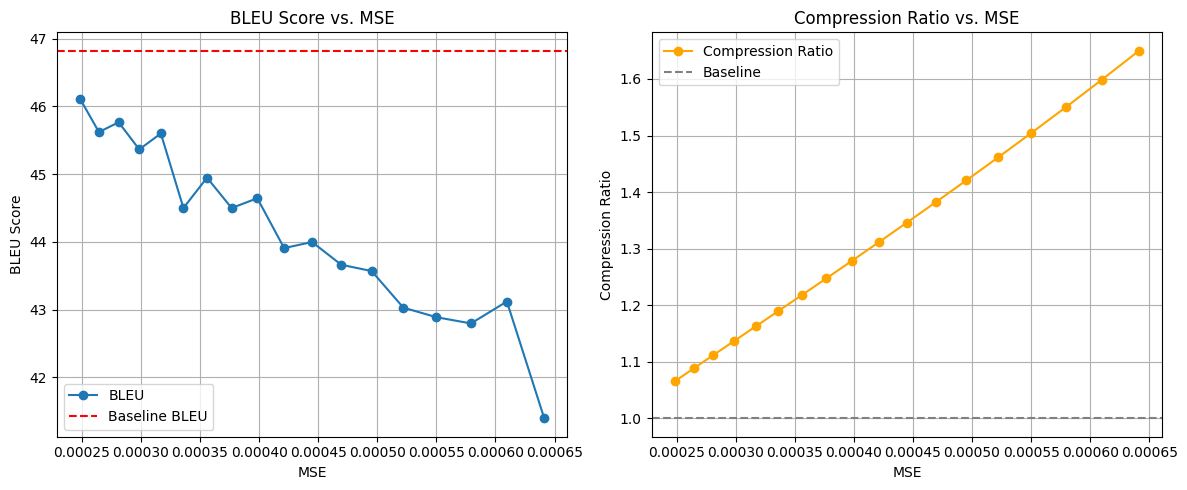

In [20]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: BLEU Score vs. MSE
axs[0].plot(mse, bleu_scores, marker='o', linestyle='-',label='BLEU')
axs[0].axhline(baseline_bleu, color='red', linestyle='--',label='Baseline BLEU')  # Add a horizontal line at y=1
axs[0].set_xlabel('MSE')
axs[0].set_ylabel('BLEU Score')
axs[0].set_title('BLEU Score vs. MSE')
axs[0].grid(True)
axs[0].legend()

# Second subplot: Compression Ratio vs. MSE
axs[1].plot(mse, compression_ratio, marker='o', linestyle='-', color='orange',label='Compression Ratio')
axs[1].axhline(1, color='gray', linestyle='--',label='Baseline')  # Add a horizontal line at y=1
axs[1].set_xlabel('MSE')
axs[1].set_ylabel('Compression Ratio')
axs[1].set_title('Compression Ratio vs. MSE')
axs[1].grid(True)
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [44]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5)

W0 = WeightArrayStepPruning(original_atten_block_weight_array_0,'array',0.001,1,1,512,512)
W1 = WeightArrayStepPruning(original_atten_block_weight_array_1,'array',0.001,1,1,512,512)
W2 = WeightArrayStepPruning(original_atten_block_weight_array_2,'array',0.001,1,1,512,512)
W3 = WeightArrayStepPruning(original_atten_block_weight_array_3,'array',0.001,1,1,512,512)
W4 = WeightArrayStepPruning(original_atten_block_weight_array_4,'array',0.001,1,1,512,512)
W5 = WeightArrayStepPruning(original_atten_block_weight_array_5,'array',0.001,1,1,512,512)

mse1 = []
bleu_scores1 = []
compression_ratio1 = []

for i in range(450):
        atten_block_weight_array_0 = W0.iterative_approximation_step2()
        atten_block_weight_array_1 = W1.iterative_approximation_step2()
        atten_block_weight_array_2 = W2.iterative_approximation_step2()
        atten_block_weight_array_3 = W3.iterative_approximation_step2()
        atten_block_weight_array_4 = W4.iterative_approximation_step2()
        atten_block_weight_array_5 = W5.iterative_approximation_step2()

for i in range(5):
    for i in range(20):
        atten_block_weight_array_0 = W0.iterative_approximation_step2()
        atten_block_weight_array_1 = W1.iterative_approximation_step2()
        atten_block_weight_array_2 = W2.iterative_approximation_step2()
        atten_block_weight_array_3 = W3.iterative_approximation_step2()
        atten_block_weight_array_4 = W4.iterative_approximation_step2()
        atten_block_weight_array_5 = W5.iterative_approximation_step2()

    W0_MSE = (W0.average_mse_array()+W1.average_mse_array()+W2.average_mse_array()+W3.average_mse_array()+W4.average_mse_array()+W5.average_mse_array())/6
    mse1.append(W0_MSE)
    compression_ratio1.append(W0.compression_ratio())

    set_layer_weight(model.model.encoder.layers[0],atten_block_weight_array_0)
    set_layer_weight(model.model.encoder.layers[1],atten_block_weight_array_1)
    set_layer_weight(model.model.encoder.layers[2],atten_block_weight_array_2)
    set_layer_weight(model.model.encoder.layers[3],atten_block_weight_array_3)
    set_layer_weight(model.model.encoder.layers[4],atten_block_weight_array_4)
    set_layer_weight(model.model.encoder.layers[5],atten_block_weight_array_5)
    bleu = compute_bleu_score(model,source_texts,target_texts)
    bleu_scores1.append(bleu)

In [56]:
mse1

[0.0006338482011826171,
 0.000598843087955282,
 0.0005655505513014364,
 0.0005341493545200487,
 0.0005041113263468138,
 0.00047561412492850874,
 0.00044865056016415273,
 0.0004233319288022618,
 0.0003993980427368252,
 0.0003767285593650558,
 0.0003551968759017063,
 0.00033465136668241104,
 0.00031528862346270225,
 0.0002970007299740708,
 0.0002796293957919382]

In [58]:
compression_ratio1

[1.6291701570917885,
 1.5626734159860012,
 1.5013921055551778,
 1.444735799685171,
 1.3921999524238922,
 1.3433508312862117,
 1.2978135149714247,
 1.2552622521854764,
 1.215412656878001,
 1.1780153443586778,
 1.1428507072136427,
 1.1097245997581748,
 1.0784647518776629,
 1.0489177723741652,
 1.0209466317775209]

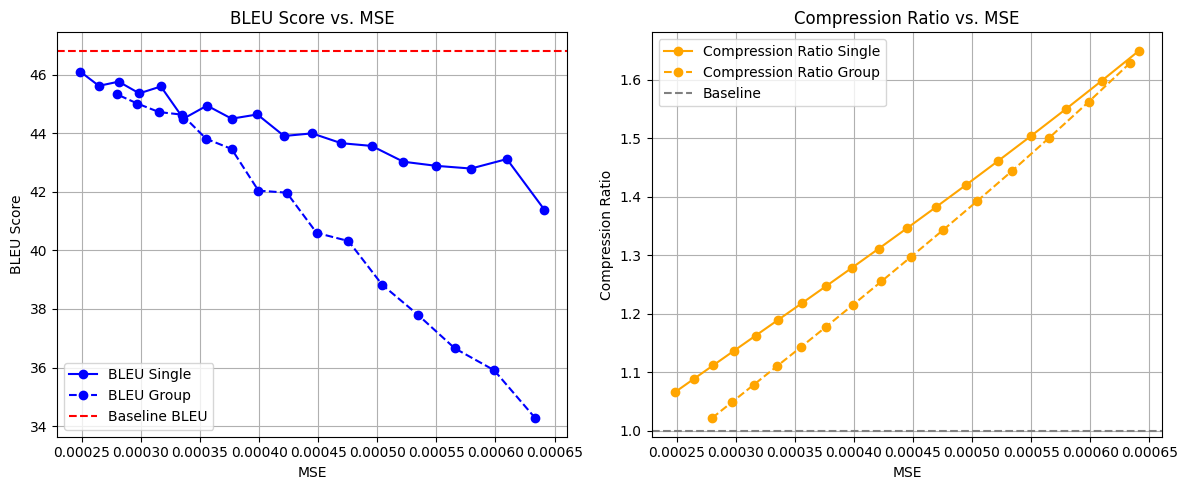

In [60]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: BLEU Score vs. MSE
axs[0].plot(mse, bleu_scores, marker='o', linestyle='-', color='blue',label='BLEU Single')
axs[0].plot(mse1, bleu_scores1, marker='o', linestyle='--', color='blue',label='BLEU Group')
axs[0].axhline(baseline_bleu, color='red', linestyle='--',label='Baseline BLEU')  # Add a horizontal line at y=1
axs[0].set_xlabel('MSE')
axs[0].set_ylabel('BLEU Score')
axs[0].set_title('BLEU Score vs. MSE')
axs[0].grid(True)
axs[0].legend()

# Second subplot: Compression Ratio vs. MSE
axs[1].plot(mse, compression_ratio, marker='o', linestyle='-',color='orange',label='Compression Ratio Single')
axs[1].plot(mse1, compression_ratio1, marker='o', linestyle='--', color='orange',label='Compression Ratio Group')
axs[1].axhline(1, color='gray', linestyle='--',label='Baseline')  # Add a horizontal line at y=1
axs[1].set_xlabel('MSE')
axs[1].set_ylabel('Compression Ratio')
axs[1].set_title('Compression Ratio vs. MSE')
axs[1].grid(True)
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [103]:
set_layer_weight(model.model.encoder.layers[0],original_atten_block_weight_array_0)
set_layer_weight(model.model.encoder.layers[1],original_atten_block_weight_array_1)
set_layer_weight(model.model.encoder.layers[2],original_atten_block_weight_array_2)
set_layer_weight(model.model.encoder.layers[3],original_atten_block_weight_array_3)
set_layer_weight(model.model.encoder.layers[4],original_atten_block_weight_array_4)
set_layer_weight(model.model.encoder.layers[5],original_atten_block_weight_array_5)

W0 = WeightArrayStepPruning(original_atten_block_weight_array_0,'weight',0.001,1,1,512,512)
W1 = WeightArrayStepPruning(original_atten_block_weight_array_1,'weight',0.001,1,1,512,512)
W2 = WeightArrayStepPruning(original_atten_block_weight_array_2,'weight',0.001,1,1,512,512)
W3 = WeightArrayStepPruning(original_atten_block_weight_array_3,'weight',0.001,1,1,512,512)
W4 = WeightArrayStepPruning(original_atten_block_weight_array_4,'weight',0.001,1,1,512,512)
W5 = WeightArrayStepPruning(original_atten_block_weight_array_5,'weight',0.001,1,1,512,512)


# WWWWW = W0.current_reconstructed_weight
# WWWWW.shape
mse2 = []
bleu_scores2 = []
compression_ratio2 = []

for i in range(1):
        atten_block_weight_array_0 = W0.iterative_approximation_step3()
        atten_block_weight_array_1 = W1.iterative_approximation_step3()
        atten_block_weight_array_2 = W2.iterative_approximation_step3()
        atten_block_weight_array_3 = W3.iterative_approximation_step3()
        atten_block_weight_array_4 = W4.iterative_approximation_step3()
        atten_block_weight_array_5 = W5.iterative_approximation_step3()
        print(i)

# for i in range(1):
#     for i in range(20):
#         atten_block_weight_array_0 = W0.iterative_approximation_step3()
#         atten_block_weight_array_1 = W1.iterative_approximation_step3()
#         atten_block_weight_array_2 = W2.iterative_approximation_step3()
#         atten_block_weight_array_3 = W3.iterative_approximation_step3()
#         atten_block_weight_array_4 = W4.iterative_approximation_step3()
#         atten_block_weight_array_5 = W5.iterative_approximation_step3()

#     W0_MSE = (W0.average_mse_array()+W1.average_mse_array()+W2.average_mse_array()+W3.average_mse_array()+W4.average_mse_array()+W5.average_mse_array())/6
#     mse2.append(W0_MSE)

#     compression_ratio2.append(W0.compression_ratio())
#     set_layer_weight(model.model.encoder.layers[0],atten_block_weight_array_0)
#     set_layer_weight(model.model.encoder.layers[1],atten_block_weight_array_1)
#     set_layer_weight(model.model.encoder.layers[2],atten_block_weight_array_2)
#     set_layer_weight(model.model.encoder.layers[3],atten_block_weight_array_3)
#     set_layer_weight(model.model.encoder.layers[4],atten_block_weight_array_4)
#     set_layer_weight(model.model.encoder.layers[5],atten_block_weight_array_5)
#     bleu = compute_bleu_score(model,source_texts,target_texts)
#     bleu_scores2.append(bleu)



ValueError: NZ cannot be larger than the number of elements in v1 divided by Tc